### Instalacja potrzebnych bibliotek

In [1]:
pip install ipywidgets # interaktywne widżety HTML dla notebooków Jupyter i jądra IPython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.9 MB/s eta 0:00:00


In [2]:
pip install keras 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Importowanie wymaganych bibliotek

In [33]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Dense # głęboko połączona warstwa przekazująca neurony dalej (batch, size)
from tensorflow.keras.layers import Flatten # "spłaszcza" dane wejściowe, przekształca w 1wymiarową tablicę; nie wpływa na wielkość partii
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization #warstwa normalizująca dane wejściowe
from tensorflow.keras.layers import Dropout # odrzuca część losową informacji, gdy sieć wyciąga za dużo informacji
from tensorflow.keras.layers import LSTM # warstwa pamięci długookresowej (sztuczna rekurencyjna architektura sieci neuronowej RNN)
from tensorflow.keras.models import Model # grupuje warstwy w obiekt z funkacjami uczenia i wnioskowania
from tensorflow.keras.models import Sequential, load_model # do zaczytywania i wczytywania modelu
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display # tworzymy obiekt audio 
import ipywidgets as widgets
from ipywidgets import interact, interact_manual # automatyczne tworzenie kontrolek interfejsu użytkownika  (user interface UI)
from ipywidgets import interactive

from sklearn.model_selection import train_test_split # dzielenie tablic lub macierzy na losowe podzbioru trenowania i testowania. 
from ipywidgets import interact, interact_manual
from ipywidgets import interactive
from sklearn.metrics import r2_score # R2- współczynnik determinacji; funkcja oceny regresji 
from sklearn.metrics import mean_absolute_error #MAE oraz MSE (błędy)
from sklearn.metrics import mean_squared_error

##### Import bibliotek do stworzenia sieci LSTM

In [34]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler # przekształcanie cech skalując każdą z cech do określonego zakresu
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping # przerywa trenowanie, gdy monitorowana metryka przestanie się poprawiać; 
                                          # estymator ten skaluje i tłumaczy każdą cechę indywidualnie tak, że znajduje się ona w zadanym zakresie na zbiorze uczącym (np. między 0 a 1)

### Wczytanie bazy

In [62]:
# katalog z plikiem powinien się znajdować w tym samym folderze, co obecnie odpalony plik
data = pd.read_csv('monari.csv')

### Podzial na zbiór treningowy i testowy

In [63]:
# pierwsza liczba oznacza ilość wierszy, natomiast druga ilość kolumn w zbiorze danych
print(data.shape)

(2001, 6)


In [99]:
# zbiór treningowy
ratio = 0.6  # współczynnik proporcji wymiarów (0.6 w stosunku do całego zbioru danych)
N = int(len(data)*ratio)   # liczba próbek na klasę
train_df, test_df = data[:N], data[N:]   # przypisanie próbek do zmiennych
print(train_df.shape)

(1200, 6)


In [100]:
# zbiór testowy
ratio = 0.4
N = int(len(data)*ratio)
test_df, val_df = test_df[:N], test_df[N:]
print(test_df.shape)

(800, 6)


In [101]:
# funkcja oblicza podsumowanie statystyk odnoszących się do kolumny DataFrame. 
# ta funkcja podaje wartości średnie, standardowe i odstęp międzykwartylowy.
train_df.describe()

,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,9.404553,9.522976,9.234962,9.385788,42571.486667
std,4.032288,4.083562,3.979028,4.037248,63978.188043
min,2.720000,2.800000,2.710000,2.760000,261.000000
25%,5.890000,5.917500,5.760000,5.877500,11164.500000
50%,8.850000,8.930000,8.720000,8.815000,23914.000000
75%,13.458000,13.609500,13.252750,13.452000,46878.250000
max,19.255000,19.699000,19.048000,19.255000,845260.000000


In [102]:
# zapewnia obliczania w oknie kroczącym. 
# windows = rozmiar ruchomego okna, jest to liczba obserwacji użytych do obliczenia statystyki. 
# każde okno będzie miało stały rozmiar.
rolling = data.rolling(window=7)

In [103]:
# definiujemy nasz y, który chcemy przewidzieć; trenujemy model tylko na "Zamkniecie"
data_roll = pd.DataFrame()
data_roll['Zamkniecie']=train_df['Zamkniecie']

interactive(children=(IntSlider(value=50, description='lw', min=1), Button(description='Run Interact', style=B…

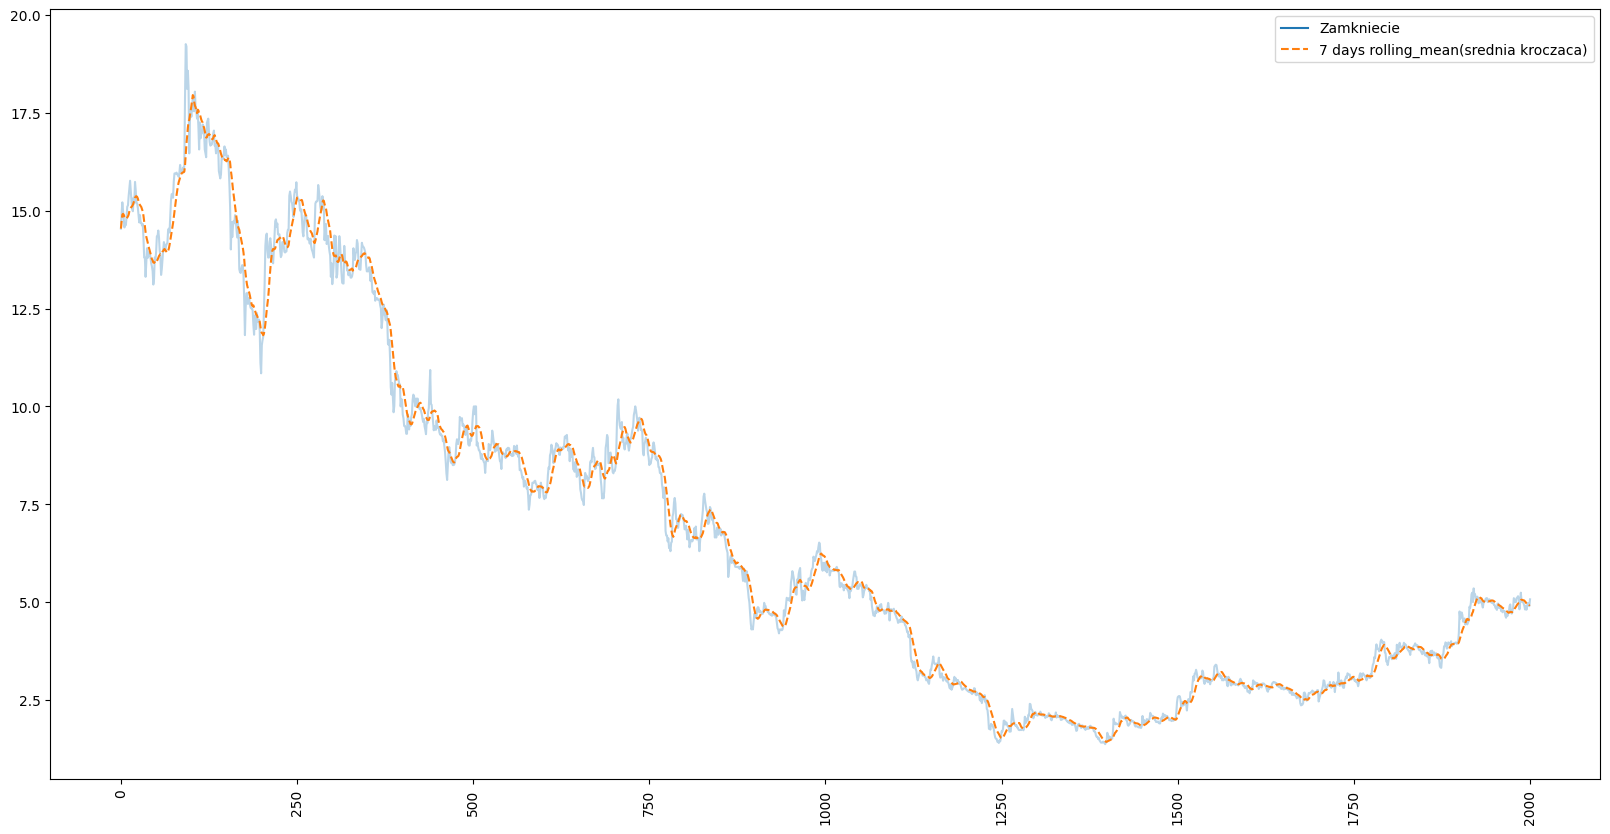

In [104]:
@widgets.interact_manual(lw=(1, 100))  #wstawia suwak do ręcznego wywoływania funkcji. Nie ma potrzeby uruchamiać za każdym razem kod, gdy zmieniamy wartość. 
def plot(lw):
  rolling = data.rolling(window=lw, center=True)
  data_roll = pd.DataFrame()
 
  data_roll['Zamkniecie']=data['Zamkniecie']
  data_roll['7 days rolling_mean(srednia kroczaca)']=data_roll['Zamkniecie'].rolling(lw, min_periods=1).mean()
  ax = data_roll.plot(style=['-', '--'], rot=90, figsize=(20, 10)) #odpowiada za rozmiar wykresu, oraz styl linii
  ax.lines[0].set_alpha(0.3)   #zmienia przeźroczystość linii wskazującej "Zamknięcie".

### Przygotowanie danych do uczenia na sieci LSTM (zmiana wymiarow macierzy, by model zaczal obrabiac dane)

In [105]:
zmienna_przewidywana = "Zamkniecie"

def prepare_dataset_to_lstm(zmienna_przewidywana, train_df, ratio):
  dataset = train_df[zmienna_przewidywana].values #numpy.ndarray
  dataset = dataset.astype('float32') #zamiana typu na float
  dataset = np.reshape(dataset, (-1, 1)) #przekształcamy tablicę; wynikowa tablica ma tylko 1 kolumnę
  scaler = MinMaxScaler(feature_range=(0, 1)) #skalowanie zmiennych do postaci (0,1)
  dataset = scaler.fit_transform(dataset) # wszystkie inne wartości są liniowo skalowane między tymi wartościami

#dzielimy uporządkowany zestaw danych do trenowania i testowania. Oblicza index punktu podziału i rozdziela dane na zestawy szkoleniowe z test. obserwacji, których można użyć do trenowania modelu, pozostawiając pozostałe do przetestowania
  train_size = int(len(dataset) * ratio)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

  return train, test, scaler

#uruchamiany tą funkcję z wyżej, przygotowanie modelu pod LSTM
train, test, scaler = prepare_dataset_to_lstm(zmienna_przewidywana, train_df, ratio=0.8) #scaler - skaluje dane do zakresu 0, 1 (tak zwana normalizacja)

In [106]:
# look_back- liczba poprzednich kroków czasowych, które mają być użyte jako zmienne wejściowe do przewidywania następnego okresu czasu, w tym przypadku domyślnie 1.
# scaler- skaluje dane do zakresu 0,1 (normalizacja)
# tworzenie back(ów); konwertujemy tablicę wartości na macierz zestawu danych
def create_dataset_lstm(dataset, look_back=1):   #look_back - wielkość kroku z którą testujemy dataset
    X, Y = [], []
    for i in range(len(dataset)-look_back-1): # żeby nie wyszło poza zasięg
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

#używamy funkcji by przygotować zestaw i przetestować zestawy danych do modelowania.
look_back = 10 #liczba probek ktora pobieramy, minimalnie jedna próbka, maksymalnie tyle, ile ma ciąg elementów
X_train, Y_train = create_dataset_lstm(train, look_back)
X_test, Y_test = create_dataset_lstm(test, look_back)

#Zmienia kształt wejścia na próbki, kroki czasowe, cechy,
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

## Uczenie modelu

In [107]:
#Tworzymy i dopasowujemy model LSTM (zmiana batch_size). W poniższym modelu jest jedno wejście w warstwie wejściowej
# i 10 neuronów w warstwie ukrytej. Warstwa wyjściowa przewiduje wartości
def lstm_model(X_train, Y_train, X_test, Y_test, batch_size=20):
  model = Sequential()  #liniowy stos warstw
  model.add(LSTM(20, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.1)) 
  model.add(Dense(8))
# definiujemy w czym będziemy wyrażać naszą jakość uczenia
  model.compile(loss='mean_squared_error', optimizer='adam') #definiujemy w czym będziemy wyrażać naszą jakośc uczenia

# epochs - Funkcja aktywacji powtarzana jest 5 razy
  model.fit(X_train, Y_train, epochs=5, batch_size=10, validation_data=(X_test, Y_test),
                      # przerwij trenowanie, gdy monitorowana metryka przestanie się poprawiać
                      callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)
  return model



## Ewaluacja modelu

In [108]:
#ewaluacja modelu #modyfikujemy niepotrzebne rzeczy
def evaluation_model(model, X_train, X_test, Y_train, Y_test, testing=False): #zmieniamy

#wykonaj prognozy
  # train_predict = model.predict(X_train)
  test_predict = model.predict(X_test)

#odwróć prognozy, przy obliczaniu błędu przekonwertujemy dane na tą samą jednostkę.  
  test_predict = scaler.inverse_transform(test_predict)
  Y_test = scaler.inverse_transform([Y_test])

#oblicz średni kwadrat błędu
  _mean_absolute_error = mean_absolute_error(Y_test[0], test_predict[:,0])   #jak mamy listę 13 elementów, to wstawiając [3,:] pobierze od 3 do 13 elementu
  _mean_squared_error = np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0]))
  print('Train Mean Absolute Error:', _mean_absolute_error)
  print('Train Root Mean Squared Error:',_mean_squared_error)
  if testing:
    return Y_test, test_predict, _mean_absolute_error, _mean_squared_error
  return Y_test, test_predict



In [109]:
def a():
    return 1, 2, (10, 20)

x,y, error = a()
print(a())
print(x,y, error)

# 1 to nasz x- Y_train, 2 nasz y- train_predict  a (10-_mean_absolute_error, 20- _mean_squared_error) nasze dołożone errory (patrz analogicznie linijkę wyżej)

(1, 2, (10, 20))
1 2 (10, 20)


In [110]:
#Model się uczy!
history = lstm_model(X_train, Y_train, X_test, Y_test, batch_size=10)

# loss to funkcja straty na zbiorze treningowym
# val_loss to funkcja straty na zbiorze walidacyjnym (im mniejsza tym lepiej)

# widzimy że z każdą kolejną epoką te dwa błędy są coraz mniejsze- zatem model dobrze się uczy. 
# im mniejsze błędy (bliższe 0- tym lepiej)

Epoch 1/5
95/95 [==============================] - 3s 10ms/step - loss: 0.1856 - val_loss: 0.0034
Epoch 2/5
95/95 [==============================] - 0s 5ms/step - loss: 0.0315 - val_loss: 0.0067
Epoch 3/5
95/95 [==============================] - 0s 5ms/step - loss: 0.0094 - val_loss: 0.0054
Epoch 4/5
95/95 [==============================] - 0s 4ms/step - loss: 0.0080 - val_loss: 0.0046
Epoch 5/5
95/95 [==============================] - 0s 5ms/step - loss: 0.0070 - val_loss: 0.0040


In [111]:
# zapisujemy model sieci neuronowej w formacie JSON
model_json = history.to_json()  #zapisanie modelu history do JSON
with open("model.json", "w") as json_file:  #utwórz plik model.json w trybie edycji i zatrzymaj w zmiennej json_file
    json_file.write(model_json)
# zapisanie wagi z modelu za pomocą funkcji save.weights. 
history.save_weights("model.h5")  #wagi są zapisywane w pliku model.h5 w katalogu lokalnym.
print("Saved model to disk")  #komentarz udanej operacji

Saved model to disk


In [112]:

evaluation_model(history,X_train, X_test, Y_train,  Y_test) #zmieniamy; dodajemy Y_test

8/8 [==============================] - 1s 3ms/step
Train Mean Absolute Error: 1.0823020289264793
Train Root Mean Squared Error: 1.20087695157385


(array([[5.05000028, 5.1999999 , 5.48999972, 5.35000001, 5.40000005,
         5.41999987, 5.59999971, 5.59999971, 5.56000007, 5.65000023,
         5.80000034, 5.84999989, 5.88000011, 6.16000002, 6.07999976,
         6.05000004, 6.13999971, 6.19999966, 6.30000022, 6.27      ,
         6.40999971, 6.52000019, 6.48999997, 6.16999993, 6.09000016,
         5.86999971, 5.80000034, 6.        , 6.        , 6.        ,
         5.80000034, 6.01999982, 5.76000022, 5.92000024, 5.95999987,
         5.94000005, 5.67999996, 5.76000022, 5.80000034, 5.80000034,
         5.80000034, 5.82000016, 5.80000034, 5.80000034, 5.82000016,
         5.86000029, 5.89999993, 5.83999998, 5.80000034, 5.73999991,
         5.40000005, 5.38000023, 5.47999981, 5.47999981, 5.40000005,
         5.44000018, 5.29999998, 5.40000005, 5.44000018, 5.35999992,
         5.44000018, 5.32000029, 5.29999998, 5.23999954, 5.09999983,
         5.38000023, 5.28000016, 5.35999992, 5.38000023, 5.53999976,
         5.65999965, 5.78000003, 5

In [113]:
Y_test, test_predict = evaluation_model(history,X_train, X_test, Y_train, Y_test) #zmieniamy

8/8 [==============================] - 0s 3ms/step
Train Mean Absolute Error: 1.0823020289264793
Train Root Mean Squared Error: 1.20087695157385


In [114]:
def visualization(Y_train, train_predict):
  N = len(Y_train[0]) 
  aa=[x for x in range(N)]  # N oznacza liczbę cech w punkcie danych
  plt.figure(figsize=(8,4))
  plt.plot(aa, Y_train[0], marker='.', label="actual") # gdy . zmienimy na * to będziemy mieli zamiast . -> *
  plt.plot(aa, train_predict[:,0], 'r', label="prediction")
  # plt.tick_params(left=False, labelleft=True) #remove ticks
  plt.tight_layout()  # dostosuj dopełnienie między polamy pomocniczymi i wokół nich
  sns.despine(top=True) # usuwamy grzbiet
  plt.subplots_adjust(left=0.07)  # położenie lewej krawędzi wykresu
  plt.title(" prediction")
  plt.xlabel('Time step', size=15)  # rozmiar czcionki dla time step 15
  plt.legend(fontsize=15)  # rozmiar czcionki elementów legendy
  plt.show()  # uruchamiamy pętle zdarzeń, wyszukujemy wszystkie aktywne obiekty figur i otwieramy jedno lub więcej inteaktywnych okien.



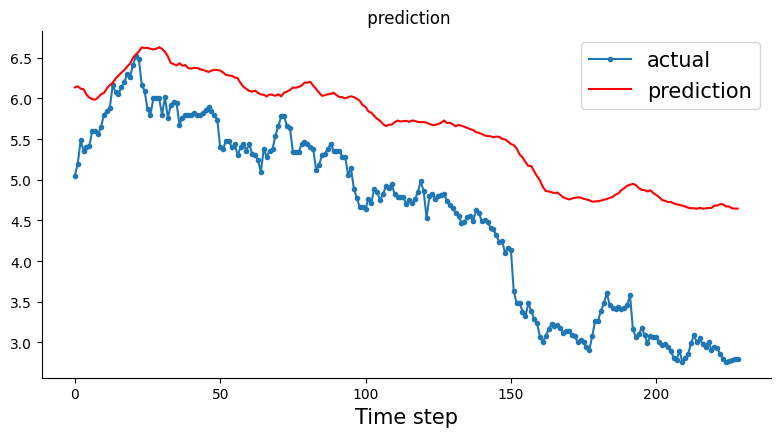

In [115]:
# Na wykresie dane nie są znormalizowane
visualization(Y_test, test_predict)

In [ ]:
#Teraz model jest troche mniej dokładny niż ten poprzedni.
#Testowy teoretycznie na początku może się wydawać, że całkiem lepiej wychwytuje, ale później, jak jest zmiana w dół, to jest nieczuły. 
#Późniejsze uderzenia wyczuwa do góry (późniejsze), ale potem znów jest spadek, więc jest stały w czasie.
#Mniej wychwytujący. Dużo brakuje do dobrego modelu.
#Można modyfikować za pomocą look_back, zmieniać ile dni wstecz itd. Jak look_back zmienimy na 10 dni, to jest bardziej czuły.
#Zmieniamy z look_back=20 na 10 dni (mniej czuły na wzrosty, bardziej na spadki)

## Zmieniamy wielkosc batch, by zobaczyc jaki wplyw ma ta zmienna na wyniki

In [116]:
# <odswiezam dane>, gdyz wymiary danych testowych i treningowych przestaja sie zgadac
train, test, scaler = prepare_dataset_to_lstm(zmienna_przewidywana, train_df, ratio=0.8)

def create_dataset_lstm(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 10 #liczba probek ktora pobieramy, minimalnie jedna probka, maksymalnie tyle, ile ma ciag elementow
X_train, Y_train = create_dataset_lstm(train, look_back)
X_test, Y_test = create_dataset_lstm(test, look_back)
print(X_test)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

[[0.1709609  0.16853592 0.1794483  ... 0.13822371 0.15337983 0.1448924 ]
 [0.16853592 0.1794483  0.18490452 ... 0.15337983 0.1448924  0.13882998]
 [0.1794483  0.18490452 0.18854198 ... 0.1448924  0.13882998 0.14792362]
 ...
 [0.01151864 0.01515611 0.00909367 ... 0.         0.00060624 0.00181873]
 [0.01515611 0.00909367 0.01151864 ... 0.00060624 0.00181873 0.00242497]
 [0.00909367 0.01151864 0.01030616 ... 0.00181873 0.00242497 0.00242497]]


In [117]:
# wielkosc batchu [10, 20, 50]
batch_start, batch_end = 30, 40 # od do
look_backs = [3,10,30] # takie look backi sprawdzamy i potem do nich mozemy wykresy zrobic


error_look_back = {}
for look_back in look_backs:
  MAEs = []
  MSEs = []
  Y_trains = []
  train_predicts = []

  X_train, Y_train = create_dataset_lstm(train, look_back)
  X_test, Y_test = create_dataset_lstm(test, look_back)
  X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
  X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
  for batch in range(batch_start, batch_end):
    print(f'-------------------------------{batch}--------------------------')
    history = lstm_model(X_train, Y_train, X_test, Y_test, batch_size=batch)
    tmp_Y_test, tmp_test_predict, MAE, MSE  = evaluation_model(history,X_train, X_test, Y_train,Y_test, testing=True) #zmieniamy
    
    MAEs.append(MAE)
    MSEs.append(MSE)
    Y_trains.append(tmp_Y_test)
    train_predicts.append(tmp_test_predict)
  error_look_back[look_back] = {"MAE":MAEs, "MSE":MSEs, "Y_trains": Y_trains, "train_predicts": train_predicts}



-------------------------------30--------------------------
Epoch 1/5
96/96 [==============================] - 3s 10ms/step - loss: 0.1959 - val_loss: 0.0040
Epoch 2/5
96/96 [==============================] - 1s 6ms/step - loss: 0.0657 - val_loss: 0.0172
Epoch 3/5
96/96 [==============================] - 1s 6ms/step - loss: 0.0163 - val_loss: 0.0174
Epoch 4/5
96/96 [==============================] - 1s 6ms/step - loss: 0.0111 - val_loss: 0.0137
Epoch 5/5
8/8 [==============================] - 0s 2ms/step
Train Mean Absolute Error: 1.7330071160380198
Train Root Mean Squared Error: 1.8191518450266602
-------------------------------31--------------------------
Epoch 1/5
96/96 [==============================] - 3s 11ms/step - loss: 0.1944 - val_loss: 0.0041
Epoch 2/5
96/96 [==============================] - 0s 5ms/step - loss: 0.0670 - val_loss: 0.0166
Epoch 3/5
96/96 [==============================] - 1s 5ms/step - loss: 0.0175 - val_loss: 0.0167
Epoch 4/5
96/96 [=========================

#### Wraz ze wzrostem batch'a, pogorszaja sie na wyniki - MAE i MSE idealnie powinny rownac sie zero, wiec generalnie im mniejsze ich wartosci, tym model uwazamy za lepszy

In [118]:
# wyświetlenie liczby kolumn i wierszy #zmieniamy
test_predict.shape

(229, 8)

In [119]:
error_look_back[3]["MSE"]

[1.8191518450266602,
 1.5584156546029868,
 1.3581142345569464,
 1.381016021142395,
 1.7869799662929824,
 1.5743587246768824,
 1.8474997525521282,
 1.836742870612772,
 1.9338695688998755,
 2.3344170647385636]

In [120]:
# wyświetlenie i posortowanie MSE
MSEs.sort()
print(MSEs)

[0.544925681392829, 0.6255916412635278, 0.7265926937884877, 0.7504263693836104, 0.8283774720523619, 0.858281265412187, 0.8685097996686505, 0.9127446571247971, 0.935885012239003, 1.0491606926022412]


<Axes: >

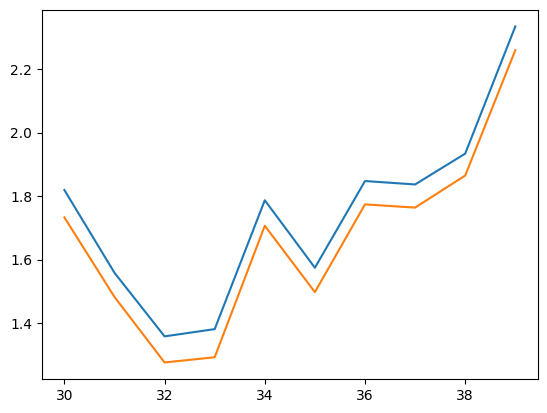

In [121]:
# wykres kreśli linię MSE, oraz MAE
look_back_to_check = 3
sns.lineplot(x=[a for a in range(batch_start, batch_end)], y=error_look_back[look_back_to_check]["MSE"])
sns.lineplot(x=[a for a in range(batch_start, batch_end)], y=error_look_back[look_back_to_check]["MAE"])


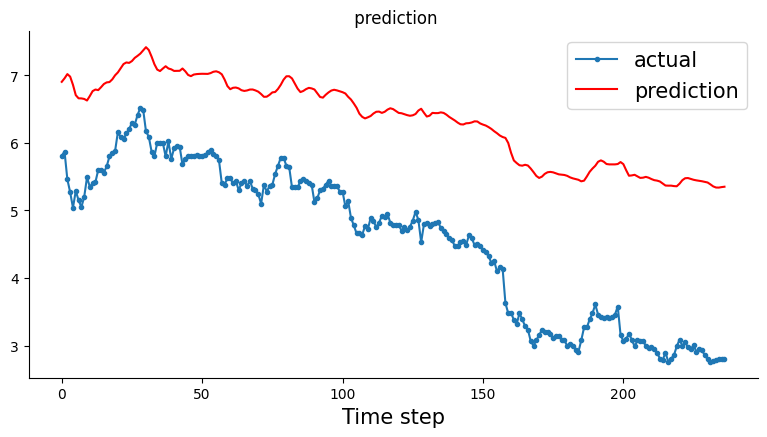

In [122]:
batch_index = 6 # to znaczy batch_start (bedzie tyle indexow ile jest od batch_start do batch_end)
look_back_to_check = 3
visualization(Y_train = error_look_back[look_back_to_check]["Y_trains"][batch_index], train_predict = error_look_back[look_back_to_check]["train_predicts"][batch_index])

In [123]:
error_look_back[3]["Y_trains"][0]

array([[5.80999976, 5.86999971, 5.46      , 5.26999976, 5.03999988,
        5.29000007, 5.14999986, 5.05000028, 5.1999999 , 5.48999972,
        5.35000001, 5.40000005, 5.41999987, 5.59999971, 5.59999971,
        5.56000007, 5.65000023, 5.80000034, 5.84999989, 5.88000011,
        6.16000002, 6.07999976, 6.05000004, 6.13999971, 6.19999966,
        6.30000022, 6.27      , 6.40999971, 6.52000019, 6.48999997,
        6.16999993, 6.09000016, 5.86999971, 5.80000034, 6.        ,
        6.        , 6.        , 5.80000034, 6.01999982, 5.76000022,
        5.92000024, 5.95999987, 5.94000005, 5.67999996, 5.76000022,
        5.80000034, 5.80000034, 5.80000034, 5.82000016, 5.80000034,
        5.80000034, 5.82000016, 5.86000029, 5.89999993, 5.83999998,
        5.80000034, 5.73999991, 5.40000005, 5.38000023, 5.47999981,
        5.47999981, 5.40000005, 5.44000018, 5.29999998, 5.40000005,
        5.44000018, 5.35999992, 5.44000018, 5.32000029, 5.29999998,
        5.23999954, 5.09999983, 5.38000023, 5.28